# Performance Analysis
## joint vs. baseline QASRL/QANom models

In [1]:
import json, sys, os
from typing import Tuple, Dict, List, Iterable, Any, Callable, Union, Optional
import pandas as pd
import numpy as np
import torch
import itertools
from collections import defaultdict, Counter
%matplotlib inline
import matplotlib.pyplot as plt

import datasets
import qanom
from qanom.annotations.common import read_annot_csv

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


def report_overlap(**kwargs):
    assert len(kwargs)==2
    (nm1, s1), (nm2, s2) = tuple(kwargs.items())
    s1, s2 = set(s1), set(s2)
    print(f"|{nm1}|={len(s1)}, |{nm2}|={len(s2)};   Union: {len(s1|s2)}  Intersection: {len(s1&s2)} ")
    print(f"|{nm1}-{nm2}|={len(s1-s2)}, |{nm2}-{nm1}|={len(s2-s1)};   ")

def plot_counter_as_pie_chart(counter, title=None):
    items = list(counter.items())
    items = sorted(items, key=lambda kv: kv[0]) # sort by key
    labels, sizes = zip(*items)

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={"color":"orange"})
    if title:
        fig1.suptitle(title, fontsize=14, color="orange")
    

def set_key_column(df, sent_id_lbl, pred_idx_lbl):
    df['key'] = df.apply(lambda r: f"{r[sent_id_lbl]}_{r[pred_idx_lbl]}", axis=1)

def arr_to_buckets(arr: Iterable[int], buckets: Dict[Tuple[int, int], str]):
    def to_bucket(e):
        for (start, end), label in buckets.items():
            if e in list(range(start, end)):
                return label
        return None
    return [to_bucket(e) for e in arr]



# Helper functions for jupyter
from IPython.display import HTML, display
import tabulate
import matplotlib.pyplot as plt
# usefull general utils
def display_table(table):
    display(HTML(tabulate.tabulate(table, tablefmt='html')))

def display_ndict(nested_dict: Dict[str, Dict[str, Any]], with_mean=True, pprint: Callable = None):
    """ Display two-level nested dict as a pretty table. """
    if not pprint:
        pprint = lambda x:x
    row_labels = list(nested_dict.keys())
    column_labels = list(list(nested_dict.values())[0].keys())
    as_tabular = [["-"] + column_labels] + \
                 [[row] + [pprint(nested_dict[row][col]) for col in column_labels]
                  for row in row_labels]
    if with_mean:
        as_tabular[0] += ["mean"]
        for i in range(1, len(as_tabular)):
            mean = np.mean(as_tabular[i][1:])
            as_tabular[i] += [mean]
    display_table(as_tabular)

### Preperations 
Load datasets and predictions

In [2]:
# Predictions - qanom, joint vs baseline
joint_qanom_predictions_fn = "../trained_models/t5_qanom-joint-23.03.22/generated_predictions.csv"
baseline_qanom_predictions_fn = "../trained_models/t5_30ep-qanom-baseline-13.03.22/generated_predictions.csv"
joint_qanom_predictions_df = pd.read_csv(joint_qanom_predictions_fn)
baseline_qanom_predictions_df = pd.read_csv(baseline_qanom_predictions_fn)


In [2]:
# Datasets
qanom_dataset = datasets.load_dataset("biu-nlp/qanom")
# qasrl_dataset = datasets.load_dataset("kleinay/qa_srl")

qanom_test_df = qanom_dataset['test'].to_pandas()
qanom_dev_df = qanom_dataset['validation'].to_pandas()
qanom_train_df = qanom_dataset['train'].to_pandas()

for df in (qanom_test_df, qanom_dev_df, qanom_train_df):
    set_key_column(df, 'sent_id', 'predicate_idx')


# Prepare Helper Function: Segregate evaluation by column value
qanom_test_df2 = pd.DataFrame(qanom_dataset["test"])                              
from run_evaluation import run_qanom_evaluation

def evaluate_precision_by_column(predictions_df, column_name, take=None):
    values = predictions_df[column_name].unique().tolist()
    if take is not None:
        values = set(values) & set(take)
    eval_per_val = {} # {value : (UA precision, LA precision)}
    for val in values:
        part_pred_df = predictions_df[predictions_df[column_name]==val].copy()
        print(f"Evaluating for {column_name} == '{val}': (Notice that recall might be un-informative!)")
        eval_results = run_qanom_evaluation(part_pred_df, qanom_test_df2.copy())
        print(eval_results[:2], "\n")  
        eval_per_val[val] = (eval_results[0].prec(), eval_results[1].prec())
    return eval_per_val    

No config specified, defaulting to: qanom/default
Reusing dataset qanom (/home/nlp/kleinay/.cache/huggingface/datasets/biu-nlp___qanom/default/1.1.0/44d54349c6d3f70e326208bf63485003c5410d38a6aae87eb80d74cf887627d0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
qadisc_dataset = datasets.load_dataset("biu-nlp/qa_discourse") 

### Num-answer distribution


In [4]:
for split in ('train', 'validation', 'test'):
    df = qasrl_dataset[split].to_pandas()
    set_key_column(df, 'sent_id', 'predicate_idx')
    print("sentences: ", df.sent_id.nunique())
    print("predicates: ", df.key.nunique())
    

NameError: name 'qasrl_dataset' is not defined

In [44]:
for split in ('train', 'validation', 'test'):
    print("\n", split)
    df = qadisc_dataset[split].to_pandas()#.sentence.nunique()
    print("sentences:", df.sent_id.nunique())
    print("sentences with no QAs:", df.question.str.len().value_counts()[0])
    print("QAs:", df.answers.str.len().sum())
    



 train
sentences: 7994
sentences with no QAs: 1655
QAs: 10985

 validation
sentences: 1834
sentences with no QAs: 498
QAs: 2632

 test
sentences: 1779
sentences with no QAs: 443
QAs: 2996


In [ ]:
d=qanom_dataset['test']
d['answers']

In [24]:
# qasrl_dataset['train'][0]

d=qanom_dataset['train']
df=d.to_pandas()
print(df.shape)
# df = df[df['question'].str.len()!=0]
# print(df.shape)
df.groupby(['sent_id', 'predicate'])['question'].count().value_counts()
# n_answers = [len(d) for d in qasrl_dataset['train']['answers']]
# Counter(n_answers)

(29705, 9)


1    15189
2     3742
3     1501
4      452
5      109
6       12
7        9
8        4
9        1
Name: question, dtype: int64

## Anaylze by lexical overlap 


In [6]:

def get_verb_form_set(data):
    return set(data['verb_form'])

nom_train_vrbs = get_verb_form_set(qanom_dataset['train'])
nom_dev_vrbs = get_verb_form_set(qanom_dataset['validation'])
report_overlap(nom_train_vrbs=nom_train_vrbs, nom_dev_vrbs=nom_dev_vrbs )
vrb_train_vrbs = get_verb_form_set(qasrl_dataset['train'])
vrb_dev_vrbs = get_verb_form_set(qasrl_dataset['validation'])
report_overlap(vrb_train_vrbs=vrb_train_vrbs, vrb_dev_vrbs=vrb_dev_vrbs )
joint_train_vrbs = nom_train_vrbs | vrb_train_vrbs
report_overlap(joint_train_vrbs=joint_train_vrbs, nom_dev_vrbs=nom_dev_vrbs)


|nom_train_vrbs|=1569, |nom_dev_vrbs|=880;   Union: 1728  Intersection: 721 
|nom_train_vrbs-nom_dev_vrbs|=848, |nom_dev_vrbs-nom_train_vrbs|=159;   
|vrb_train_vrbs|=3039, |vrb_dev_vrbs|=468;   Union: 3053  Intersection: 454 
|vrb_train_vrbs-vrb_dev_vrbs|=2585, |vrb_dev_vrbs-vrb_train_vrbs|=14;   
|joint_train_vrbs|=3384, |nom_dev_vrbs|=880;   Union: 3451  Intersection: 813 
|joint_train_vrbs-nom_dev_vrbs|=2571, |nom_dev_vrbs-joint_train_vrbs|=67;   


In [3]:
qanom_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sent_id', 'predicate_idx', 'predicate', 'is_verbal', 'verb_form', 'question', 'answers', 'answer_ranges'],
        num_rows: 29705
    })
    validation: Dataset({
        features: ['sentence', 'sent_id', 'predicate_idx', 'predicate', 'is_verbal', 'verb_form', 'question', 'answers', 'answer_ranges'],
        num_rows: 7502
    })
    test: Dataset({
        features: ['sentence', 'sent_id', 'predicate_idx', 'predicate', 'is_verbal', 'verb_form', 'question', 'answers', 'answer_ranges'],
        num_rows: 6937
    })
})

## Output Role Distribution

Counter({'what': 1611, 'who': 1220, 'how': 673, 'where': 540, 'when': 410, 'why': 366, 'how much': 30, 'how long': 27})


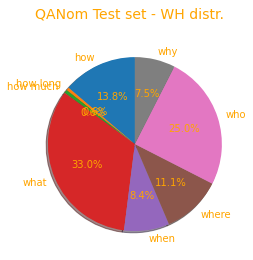

In [29]:
## for simplicity - by WH word
qanom_questions = qanom_dataset['test']['question'] 
qanom_wh_words = [q[0] for q in qanom_questions if q]
qanom_wh_dist = Counter(qanom_wh_words)
print(qanom_wh_dist)
plot_counter_as_pie_chart(qanom_wh_dist, "QANom Test set - WH distr.")

In [ ]:
qasrl_questions = qasrl_dataset['validation']['question'] 
qasrl_wh_words = [q[0] for q in qasrl_questions if q]
qasrl_wh_dist = Counter(qasrl_wh_words)
print(qasrl_wh_dist)
plot_counter_as_pie_chart(qasrl_wh_dist)

In [ ]:
predicted_qanom_by_joint_fn = "joint_on_qanom_generated_predictions.csv"
predicted_qanom_by_joint_df = pd.read_csv(predicted_qanom_by_joint_fn)
predicted_qanom_by_joint_df['key'] = predicted_qanom_by_joint_df.apply(lambda r: f"{r['qasrl_id']}_{r['verb_idx']}", axis=1)
predicted_qanom_wh_words = predicted_qanom_by_joint_df.question.apply(lambda s: s.split()[0]).tolist()
predicted_qanom_wh_dist = Counter(predicted_qanom_wh_words)
print(predicted_qanom_wh_dist)
plot_counter_as_pie_chart(predicted_qanom_wh_dist)

## QA Redundancy
Investigate whether the best model (joint) is producing redundant QAs - how many times it produces the same answer twich or the same question twice 

In [17]:
# count duplicate QAs
# By Question
n_qs = predicted_qanom_by_joint_df[['key', 'question']].shape[0]
n_unique_qs = predicted_qanom_by_joint_df[['key', 'question']].drop_duplicates().shape[0]
n_redund_qa = n_qs - n_unique_qs 
print(f"Out of {n_qs} questions, {n_redund_qa} ({100*n_redund_qa/n_qs:.01f}%) are repeated")
# By Answer
n_as = predicted_qanom_by_joint_df[['key', 'answer']].shape[0]
n_unique_as = predicted_qanom_by_joint_df[['key', 'answer']].drop_duplicates().shape[0]
n_redund_ans = n_as - n_unique_as 
print(f"Out of {n_as} answers, {n_redund_ans} ({100*n_redund_ans/n_as:.01f}%) are repeated")
# By QA
n_as = predicted_qanom_by_joint_df[['key', 'question', 'answer']].shape[0]
n_unique_as = predicted_qanom_by_joint_df[['key', 'question', 'answer']].drop_duplicates().shape[0]
n_redund_ans = n_as - n_unique_as 
print(f"Out of {n_as} QAs, {n_redund_ans} ({100*n_redund_ans/n_as:.01f}%) are repeated")


Out of 5221 questions, 106 (2.0%) are repeated
Out of 5221 answers, 6 (0.1%) are repeated
Out of 5221 QAs, 4 (0.1%) are repeated


In [24]:
dupl_qs_df = predicted_qanom_by_joint_df[predicted_qanom_by_joint_df.duplicated(['key', 'question'], keep=False)]
dupl_qs_df.to_csv("duplicated_questions.csv")

## Performance per #-QAs (output seq length)
does the model fails more in longer sequences (more QAs / longer answers)? 

does permutation sampling by |qas| mitigate this? 


Note: the prediction files are on test set.

In [21]:
gold_mean_num_qas = qanom_train_df.groupby('key').key.count().mean()
print(f"mean num of QAs at gold (all train set): {gold_mean_num_qas}")
gold_mean_num_qas = qanom_dev_df.groupby('key').key.count().mean()
print(f"mean num of QAs at gold (all dev set): {gold_mean_num_qas}")
gold_mean_num_qas = qanom_test_df.groupby('key').key.count().mean()
print(f"mean num of QAs at gold (all test set): {gold_mean_num_qas}")
predictions_df = pd.read_csv("/home/nlp/kleinay/tmp/t5-tst-summarization/qanom/qanom/linearization/all_by_answer_ordering/generated_predictions.csv")


mean num of QAs at gold (all train set): 1.3405388329798276
mean num of QAs at gold (all dev set): 1.6430135786246167
mean num of QAs at gold (all test set): 1.582344890510949


In [4]:
# Compare linearization methods

# measure mean #-QAs in predicted outputs
def anaylze_predictions(out_dir):
    model_label = out_dir.split("/")[-1]
    predictions_fn = f"{out_dir}/generated_predictions.csv"
    predictions_df = pd.read_csv(predictions_fn)
    set_key_column(predictions_df, 'qasrl_id', 'verb_idx')
    predictions_df["qa_position"] = predictions_df.groupby('key').cumcount()
    predictions_df["qa_position_group"] = predictions_df.qa_position.apply(lambda n: str(n+1) if n<3 else ">3") 
    predictions_df["num_qas"] = predictions_df.groupby('key').qa_position.transform('max') + 1
    predictions_df["num_qas_group"] = predictions_df.num_qas.apply(lambda n: str(n) if n<=3 else ">3") 
    predictions_df["num_qas_group"] = predictions_df.num_qas.apply(lambda n: str(n) if n<=3 else ">3") 
    mean_num_qas = predictions_df.groupby('key').key.count().mean()
    print(f"mean num of QAs at prediction (all test set): {mean_num_qas}")
    gold_mean_num_qas = qanom_test_df.groupby('key').key.count().mean()
    print(f"mean num of QAs at gold (all test set): {gold_mean_num_qas}")
    
    # Compute precision per (predicted) sequence-length and qa-location
    # print("precision by num_qas:", evaluate_precision_by_column(predictions_df, "num_qas")) 
    # print("precision by qa position:", evaluate_precision_by_column(predictions_df, "qa_position")) 
    # print("precision by num_qas (groups):", evaluate_precision_by_column(predictions_df, "num_qas_group")) 
    # print("precision by qa position (groups):", evaluate_precision_by_column(predictions_df, "qa_position_group")) 
    
    # Compute precisoin per dependency range (distance between argument and predicate)
    # ans_index = predictions_df.answer_range.str.split("~!~").str.get(0).str.split(":").str.get(0).astype(int)
    # dep_range = np.absolute(ans_index - predictions_df.verb_idx)
    # dependency_range_buckets = {(0,3): "1-2", (3,6):"3-5", (6,9):"6-8", (9,300):"9-Inf"}
    # predictions_df["dep_range_group"] = arr_to_buckets(dep_range, dependency_range_buckets)
    # print("precision by dependency range (groups):", evaluate_precision_by_column(predictions_df, "dep_range_group")) 
    
    # Compute precisoin per sentence length
    sentence_length = predictions_df.sentence.str.split().str.len()
    sent_len_buckets = {(0,10): "0-9", (10,20): "10-19", (20,30): "20-29", (30,50): "30-49", (50,1000):"50+"}
    predictions_df["sentence_length_group"] = arr_to_buckets(sentence_length, sent_len_buckets)
    print("precision by sentence length (groups):", evaluate_precision_by_column(predictions_df, "sentence_length_group")) 
    
    
    
    # recall_errs_df = pd.read_csv(f"{out_dir}/recall_errors.csv")
    # precision_errs_df = pd.read_csv(f"{out_dir}/precision_errors.csv")
    # instances_with_fn = recall_errs_df.key.drop_duplicates().tolist()
    # gold_instances_with_fn = qanom_test_df[qanom_test_df.key.isin(instances_with_fn)]
    # mean_num_qas_at_fn = gold_instances_with_fn.groupby('key').key.count().mean()
    # print(f"mean num of QAs (in gold) for predicates that had a False-Negative : {mean_num_qas_at_fn}")
    # instances_with_fp = precision_errs_df.key.drop_duplicates().tolist()
    # sys_instances_with_fn = predictions_df[predictions_df.key.isin(instances_with_fp)]
    # mean_num_qas_at_fp = sys_instances_with_fn.groupby('key').key.count().mean()
    # print(f"mean num of QAs (in predictions) for predicates that had a False-Positive : {mean_num_qas_at_fp}")
    # # Plot Disribution of Wh-word of mistakes
    # whs_predictions = predictions_df.question.str.split().str.get(0)
    # plot_counter_as_pie_chart(Counter(whs_predictions), f"WH distr. of predictions, {model_label}") 
    # whs_precision_errs = precision_errs_df.question.str.split().str.get(0)
    # plot_counter_as_pie_chart(Counter(whs_precision_errs), f"WH distr. of precision errors, {model_label}") 
    # whs_recall_errs = recall_errs_df.question.str.split().str.get(0)
    # plot_counter_as_pie_chart(Counter(whs_recall_errs), f"WH distr. of recall errors, {model_label}") 
    # whs_gold = qanom_test_df.question.str.split().str.get(0)
    # plot_counter_as_pie_chart(Counter(whs_gold), f"WH distr. of gold") 
    
    # # Plot QA-position of mistakes compared to base 
    # qa_pos_predictions = predictions_df.groupby(["qasrl_id", "verb_idx"]).cumcount()
    # plot_counter_as_pie_chart(Counter(qa_pos_predictions), f"QA-Position Distr. in predictions, {model_label}") 
    # qa_pos_precision_errs = precision_errs_df.qa_position
    # plot_counter_as_pie_chart(Counter(qa_pos_precision_errs), f"QA-Position Distr. in precision errors, {model_label}") 
    # qa_pos_recall_errs = recall_errs_df.qa_position
    # plot_counter_as_pie_chart(Counter(qa_pos_recall_errs), f"QA-Position Distr. in recall errors, {model_label}") 
    # qa_pos_gold = qanom_test_df.groupby(["sent_id", "predicate_idx"]).cumcount()
    # plot_counter_as_pie_chart(Counter(qa_pos_gold), f"QA-Position Distr. in gold") 
    
    
# base_dir = "/home/nlp/kleinay/tmp/t5-tst-summarization/qasrl/qasrl/linearization"
base_dir = "/home/nlp/kleinay/tmp/t5-tst-summarization/qanom/qanom/linearization"
# base_dir = "/home/nlp/kleinay/tmp/t5-tst-summarization/joint_qanom/linearization"
print(f"Base Dir: {base_dir} *** \n")
for lin in ("permutate_sample_num_of_qas", "all_by_answer_ordering"):
    output_dir = f"{base_dir}/{lin}"
    print(f"\n {lin} model:")
    anaylze_predictions(output_dir)

Base Dir: /home/nlp/kleinay/tmp/t5-tst-summarization/qanom/qanom/linearization *** 


 permutate_sample_num_of_qas model:
mean num of QAs at prediction (all test set): 2.1895509499136443
mean num of QAs at gold (all test set): 1.582344890510949
Evaluating for sentence_length_group == '30-49': (Notice that recall might be un-informative!)


/home/nlp/kleinay/miniconda3/envs/seq2seq-qasrl/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
1894it [00:21, 86.96it/s]ungrammatical question: what did someone contract someone to do? ; all core args are present in core-role active question.
1896it [00:21, 93.13it/s]ungrammatical question: what did someone contract someone to do? ; all core args are present in core-role active question.


(P: 0.593   R: 0.206   F1: 0.306, P: 0.421   R: 0.146   F1: 0.217) 

Evaluating for sentence_length_group == '20-29': (Notice that recall might be un-informative!)


2250it [00:24, 87.81it/s]ungrammatical question: what did someone instruct someone to do? ; all core args are present in core-role active question.
2248it [00:25, 89.47it/s]ungrammatical question: what did someone instruct someone to do? ; all core args are present in core-role active question.


(P: 0.623   R: 0.194   F1: 0.296, P: 0.456   R: 0.142   F1: 0.216) 

Evaluating for sentence_length_group == '10-19': (Notice that recall might be un-informative!)


798it [00:09, 87.02it/s] 

In [4]:
out_dir = f"{base_dir}/permutate_sample_num_of_qas"
model_label = out_dir.split("/")[-1]
predictions_fn = f"{out_dir}/generated_predictions.csv"
predictions_df = pd.read_csv(predictions_fn)
set_key_column(predictions_df, 'qasrl_id', 'verb_idx')
mean_num_qas = predictions_df.groupby('key').key.count().mean()
print(f"mean num of QAs at prediction (all test set): {mean_num_qas}")
# gold_mean_num_qas = qanom_test_df.groupby('key').key.count().mean()
# print(f"mean num of QAs at gold (all test set): {gold_mean_num_qas}")

recall_errs_df = pd.read_csv(f"{out_dir}/recall_errors.csv")
precision_errs_df = pd.read_csv(f"{out_dir}/precision_errors.csv")
instances_with_fn = recall_errs_df.key.drop_duplicates().tolist()
gold_instances_with_fn = qanom_test_df[qanom_test_df.key.isin(instances_with_fn)]
mean_num_qas_at_fn = gold_instances_with_fn.groupby('key').key.count().mean()
report_overlap(qanom_test_df_sents=set(qanom_test_df.sent_id), recall_errs_sents=set(recall_errs_df.qasrl_id ))
report_overlap(prediction_df_sents=set(predictions_df.qasrl_id), prec_errs_sents=set(precision_errs_df.qasrl_id ))

mean num of QAs at prediction (all test set): 2.1895509499136443
|qanom_test_df_sents|=1507, |recall_errs_sents|=844;   Union: 1507  Intersection: 844 
|qanom_test_df_sents-recall_errs_sents|=663, |recall_errs_sents-qanom_test_df_sents|=0;   
|prediction_df_sents|=1159, |prec_errs_sents|=836;   Union: 1159  Intersection: 836 
|prediction_df_sents-prec_errs_sents|=323, |prec_errs_sents-prediction_df_sents|=0;   


In [20]:
ans_index = predictions_df.answer_range.str.split("~!~").str.get(0).str.split(":").str.get(0).astype(int)
dep_range = np.absolute(ans_index - predictions_df.verb_idx)
dependency_range_buckets = {(0,3): "1-2", (3,6):"3-5", (6,9):"6-8", (9,300):"9-Inf"}
predictions_df["dep_range_group"] = arr_to_buckets(dep_range, dependency_range_buckets)
predictions_df["dep_range_group"].value_counts()
sentence_length = predictions_df.sentence.str.split().str.len()
sent_len_buckets = {(0,10): "0-9", (10,20): "10-19", (20,30): "20-29", (30,50): "30-49", (50,1000):"50+"}
predictions_df["sentence_length_group"] = arr_to_buckets(sentence_length, sent_len_buckets)
predictions_df["sentence_length_group"].value_counts()
    


1-2      1763
9-Inf    1345
3-5      1236
6-8       727
Name: dep_range_group, dtype: int64

In [9]:
x={'1-2': (0.7369614512471655, 0.530045351473923), '6-8': (0.6117824773413897, 0.4380664652567976), '9-Inf': (0.5440180586907449, 0.41309255079006774), '3-5': (0.6936416184971098, 0.4797687861271676)}
key =x.keys()
vals = np.array(list(zip(*x.values())))*100
display_table([key] + list(vals) )

1-2,6-8,9-Inf,3-5
73.69614512471655,61.17824773413897,54.401805869074494,69.36416184971098
53.004535147392296,43.80664652567976,41.309255079006775,47.97687861271676
